# Random Forest for Creditworthiness Prediction

### Install necessary packages

In [7]:
!pip install ydata-profiling
!pip install imbalanced-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=4ec5c37ff2fce8e3768d98ea2d0e37b830225c783ed9be88d3061055a04bb47b
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


### Import required libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from ydata_profiling import ProfileReport

### Load the dataset

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount", "Savings",
    "EmploymentSince", "InstallmentRate", "PersonalStatusSex", "DebtorsGuarantors",
    "ResidenceSince", "Property", "Age", "OtherInstallmentPlans", "Housing", "ExistingCredits",
    "Job", "NumPeopleLiable", "Telephone", "ForeignWorker", "CreditRisk"
]

In [10]:
df = pd.read_csv(url, delim_whitespace=True, header=None)
df.columns = columns

In [ ]:
df.head(5)

Status  Duration CreditHistory Purpose  CreditAmount Savings  \
0    A11         6           A34     A43          1169     A65   
1    A12        48           A32     A43          5951     A61   
2    A14        12           A34     A46          2096     A61   
3    A11        42           A32     A42          7882     A61   
4    A11        24           A33     A40          4870     A61   

  EmploymentSince  InstallmentRate PersonalStatusSex DebtorsGuarantors  ...  \
0             A75                4               A93              A101  ...   
1             A73                2               A92              A101  ...   
2             A74                2               A93              A101  ...   
3             A74                2               A93              A103  ...   
4             A73                3               A93              A101  ...   

   Property Age  OtherInstallmentPlans Housing ExistingCredits   Job  \
0      A121  67                   A143    A152               2  A173   
1      A121  22                   A143    A152               1  A173   
2      A121  49                   A143    A152               1  A172   
3      A122  45                   A143    A153               1  A173   
4      A124  53                   A143    A153               2  A173   

  NumPeopleLiable  Telephone ForeignWorker CreditRisk  
0               1       A192          A201          1  
1               1       A191          A201          2  
2               2       A191          A201          1  
3               2       A191          A201          1  
4               2       A191          A201          2  

[5 rows x 21 columns]

In [11]:
# Mappings for categorical variables
status_map = {'A11': '< 0 DM', 'A12': '0 <= ... < 200 DM', 'A13': '>= 200 DM', 'A14': 'no checking account'}
credit_history_map = {'A30': 'no credits/all paid', 'A31': 'all paid', 'A32': 'existing paid', 'A33': 'delay', 'A34': 'critical/other'}
purpose_map = {
    'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture', 'A43': 'radio/TV', 'A44': 'appliance', 'A45': 'repairs',
    'A46': 'education', 'A47': 'vacation', 'A48': 'retraining', 'A49': 'business', 'A410': 'other'
}
savings_map = {'A61': '< 100 DM', 'A62': '100 <= ... < 500 DM', 'A63': '500 <= ... < 1000 DM', 'A64': '>= 1000 DM', 'A65': 'unknown'}
employment_map = {'A71': 'unemployed', 'A72': '< 1 yr', 'A73': '1 <= ... < 4 yrs', 'A74': '4 <= ... < 7 yrs', 'A75': '>= 7 yrs'}
personal_status_map = {
    'A91': 'male div/sep', 'A92': 'female div/sep/mar', 'A93': 'male single', 'A94': 'male mar/wid', 'A95': 'female single'
}
other_debtors_map = {'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'}
property_map = {'A121': 'real estate', 'A122': 'insurance', 'A123': 'car/other', 'A124': 'unknown'}
other_installment_map = {'A141': 'bank', 'A142': 'stores', 'A143': 'none'}
housing_map = {'A151': 'rent', 'A152': 'own', 'A153': 'free'}
job_map = {
    'A171': 'unskilled non-res', 'A172': 'unskilled res', 'A173': 'skilled', 'A174': 'high qual/self'
}
telephone_map = {'A191': 'none', 'A192': 'yes'}
foreign_worker_map = {'A201': 'yes', 'A202': 'no'}

In [12]:
# Apply mappings
df['Status'] = df['Status'].map(status_map)
df['CreditHistory'] = df['CreditHistory'].map(credit_history_map)
df['Purpose'] = df['Purpose'].map(purpose_map)
df['Savings'] = df['Savings'].map(savings_map)
df['EmploymentSince'] = df['EmploymentSince'].map(employment_map)
df['PersonalStatusSex'] = df['PersonalStatusSex'].map(personal_status_map)
df['DebtorsGuarantors'] = df['DebtorsGuarantors'].map(other_debtors_map)
df['Property'] = df['Property'].map(property_map)
df['OtherInstallmentPlans'] = df['OtherInstallmentPlans'].map(other_installment_map)
df['Housing'] = df['Housing'].map(housing_map)
df['Job'] = df['Job'].map(job_map)
df['Telephone'] = df['Telephone'].map(telephone_map)
df['ForeignWorker'] = df['ForeignWorker'].map(foreign_worker_map)

In [ ]:
df.head(5)

Status  Duration   CreditHistory    Purpose  CreditAmount  \
0               < 0 DM         6  critical/other   radio/TV          1169   
1    0 <= ... < 200 DM        48   existing paid   radio/TV          5951   
2  no checking account        12  critical/other  education          2096   
3               < 0 DM        42   existing paid  furniture          7882   
4               < 0 DM        24           delay  car (new)          4870   

    Savings   EmploymentSince  InstallmentRate   PersonalStatusSex  \
0   unknown          >= 7 yrs                4         male single   
1  < 100 DM  1 <= ... < 4 yrs                2  female div/sep/mar   
2  < 100 DM  4 <= ... < 7 yrs                2         male single   
3  < 100 DM  4 <= ... < 7 yrs                2         male single   
4  < 100 DM  1 <= ... < 4 yrs                3         male single   

  DebtorsGuarantors  ...     Property Age  OtherInstallmentPlans Housing  \
0              none  ...  real estate  67                   none     own   
1              none  ...  real estate  22                   none     own   
2              none  ...  real estate  49                   none     own   
3         guarantor  ...    insurance  45                   none    free   
4              none  ...      unknown  53                   none    free   

  ExistingCredits            Job NumPeopleLiable  Telephone ForeignWorker  \
0               2        skilled               1        yes           yes   
1               1        skilled               1       none           yes   
2               1  unskilled res               2       none           yes   
3               1        skilled               2       none           yes   
4               2        skilled               2       none           yes   

  CreditRisk  
0          1  
1          2  
2          1  
3          1  
4          2  

[5 rows x 21 columns]

### Initial Data Exploration

In [13]:
# Convert target variable to binary (1 = Good, 0 = Bad)
df['CreditRisk'] = df['CreditRisk'].map({1: 1, 2: 0})

In [14]:
# Show shape and preview
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1000, 21)


Status  Duration   CreditHistory    Purpose  CreditAmount  \
0               < 0 DM         6  critical/other   radio/TV          1169   
1    0 <= ... < 200 DM        48   existing paid   radio/TV          5951   
2  no checking account        12  critical/other  education          2096   
3               < 0 DM        42   existing paid  furniture          7882   
4               < 0 DM        24           delay  car (new)          4870   

    Savings   EmploymentSince  InstallmentRate   PersonalStatusSex  \
0   unknown          >= 7 yrs                4         male single   
1  < 100 DM  1 <= ... < 4 yrs                2  female div/sep/mar   
2  < 100 DM  4 <= ... < 7 yrs                2         male single   
3  < 100 DM  4 <= ... < 7 yrs                2         male single   
4  < 100 DM  1 <= ... < 4 yrs                3         male single   

  DebtorsGuarantors  ...     Property Age  OtherInstallmentPlans Housing  \
0              none  ...  real estate  67                   none     own   
1              none  ...  real estate  22                   none     own   
2              none  ...  real estate  49                   none     own   
3         guarantor  ...    insurance  45                   none    free   
4              none  ...      unknown  53                   none    free   

  ExistingCredits            Job NumPeopleLiable  Telephone ForeignWorker  \
0               2        skilled               1        yes           yes   
1               1        skilled               1       none           yes   
2               1  unskilled res               2       none           yes   
3               1        skilled               2       none           yes   
4               2        skilled               2       none           yes   

  CreditRisk  
0          1  
1          0  
2          1  
3          1  
4          0  

[5 rows x 21 columns]

In [ ]:
print("\nData types and missing values:")
df.info()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Status                 1000 non-null   object
 1   Duration               1000 non-null   int64 
 2   CreditHistory          1000 non-null   object
 3   Purpose                1000 non-null   object
 4   CreditAmount           1000 non-null   int64 
 5   Savings                1000 non-null   object
 6   EmploymentSince        1000 non-null   object
 7   InstallmentRate        1000 non-null   int64 
 8   PersonalStatusSex      1000 non-null   object
 9   DebtorsGuarantors      1000 non-null   object
 10  ResidenceSince         1000 non-null   int64 
 11  Property               1000 non-null   object
 12  Age                    1000 non-null   int64 
 13  OtherInstallmentPlans  1000 non-null   object
 14  Housing                1000 non-null   ob

In [ ]:
# Check for null values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Status                   0
Duration                 0
CreditHistory            0
Purpose                  0
CreditAmount             0
Savings                  0
EmploymentSince          0
InstallmentRate          0
PersonalStatusSex        0
DebtorsGuarantors        0
ResidenceSince           0
Property                 0
Age                      0
OtherInstallmentPlans    0
Housing                  0
ExistingCredits          0
Job                      0
NumPeopleLiable          0
Telephone                0
ForeignWorker            0
CreditRisk               0
dtype: int64


In [ ]:
print("\nSummary statistics:")
print(df.describe(include='all'))


Summary statistics:
                     Status     Duration  CreditHistory   Purpose  \
count                  1000  1000.000000           1000      1000   
unique                    4          NaN              5        10   
top     no checking account          NaN  existing paid  radio/TV   
freq                    394          NaN            530       280   
mean                    NaN    20.903000            NaN       NaN   
std                     NaN    12.058814            NaN       NaN   
min                     NaN     4.000000            NaN       NaN   
25%                     NaN    12.000000            NaN       NaN   
50%                     NaN    18.000000            NaN       NaN   
75%                     NaN    24.000000            NaN       NaN   
max                     NaN    72.000000            NaN       NaN   

        CreditAmount   Savings   EmploymentSince  InstallmentRate  \
count    1000.000000      1000              1000      1000.000000   
unique      

In [15]:
# Class distribution
print("\nTarget class distribution:\n", df['CreditRisk'].value_counts())


Target class distribution:
 CreditRisk
1    700
0    300
Name: count, dtype: int64


### Data Visualization

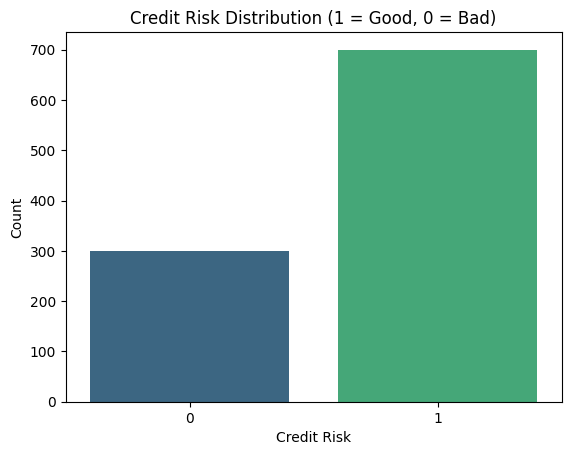

In [ ]:
# Plotting class distribution
sns.countplot(x='CreditRisk', data=df, palette='viridis')
plt.title("Credit Risk Distribution (1 = Good, 0 = Bad)")
plt.xlabel("Credit Risk")
plt.ylabel("Count")
plt.show()

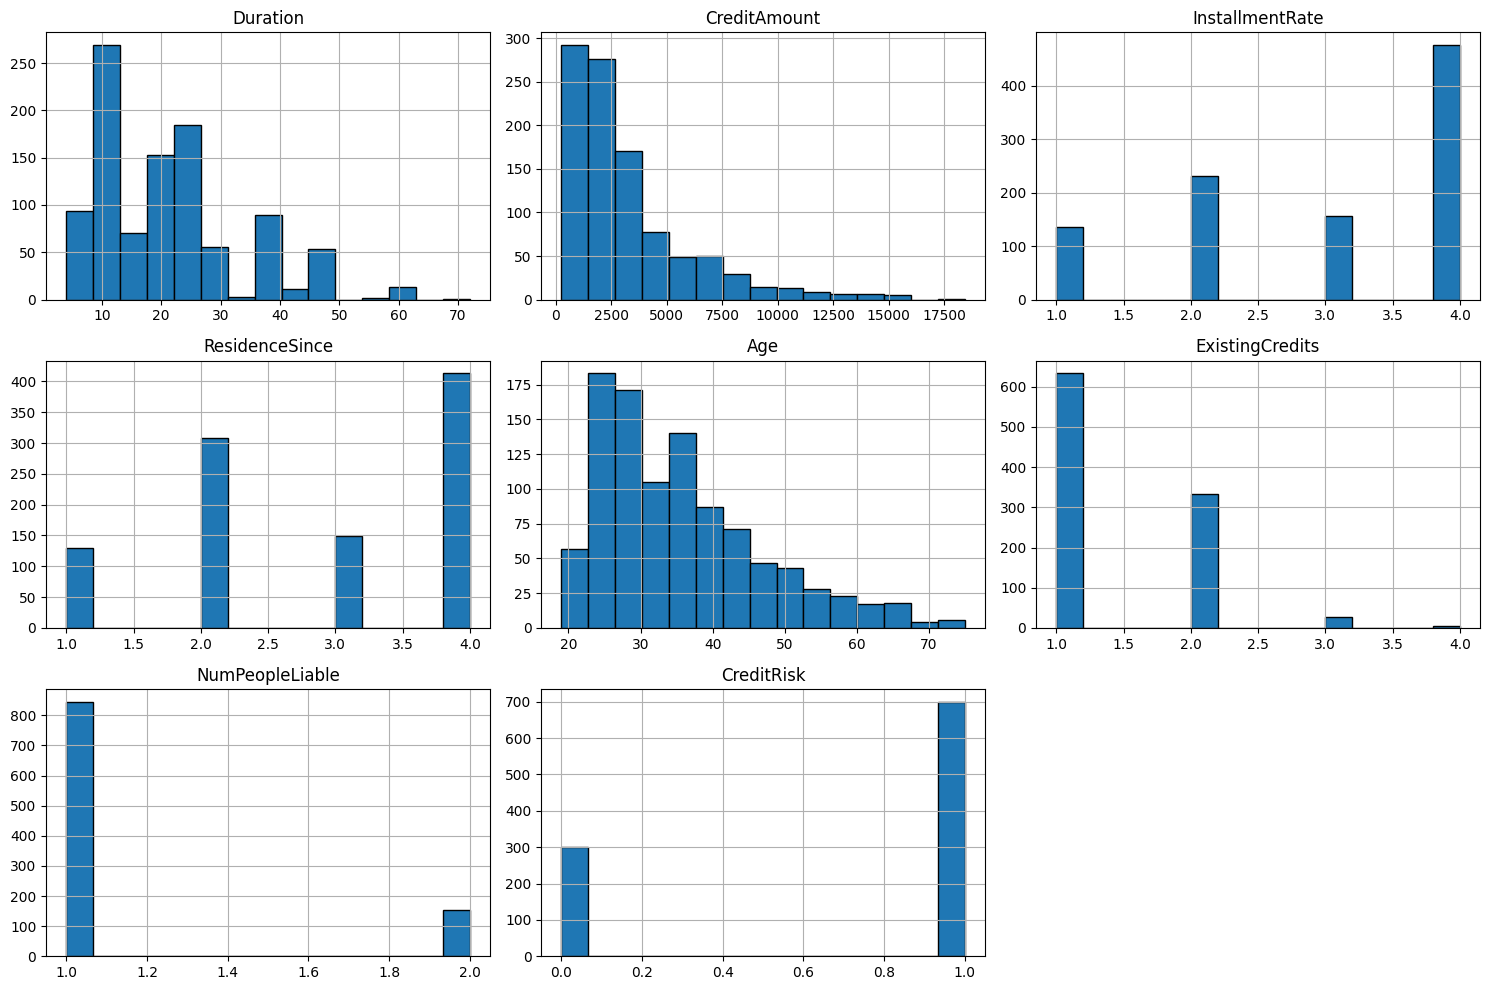

In [ ]:
# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[num_cols].hist(bins=15, figsize=(15, 10), layout=(3, 3), edgecolor='black')
plt.tight_layout()
plt.show()

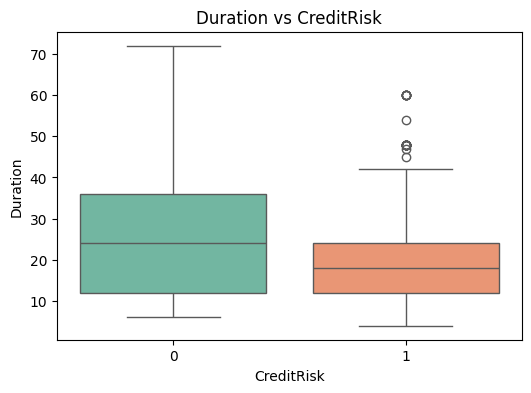

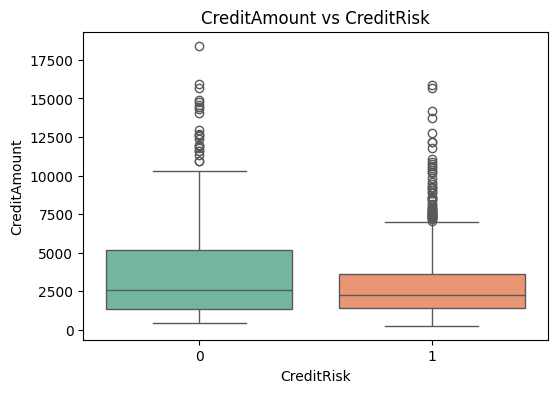

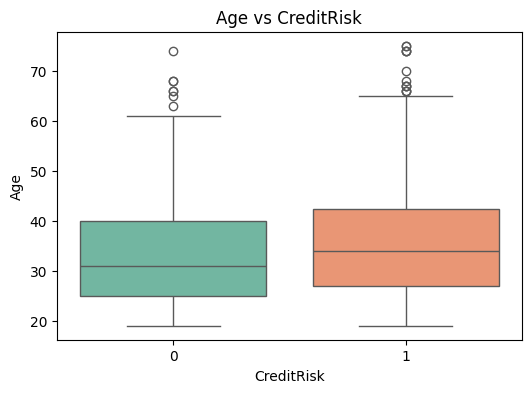

In [ ]:
for col in ['Duration', 'CreditAmount', 'Age']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='CreditRisk', y=col, data=df, palette='Set2')
    plt.title(f"{col} vs CreditRisk")
    plt.show()

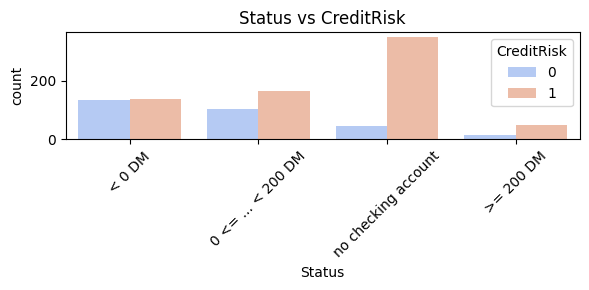

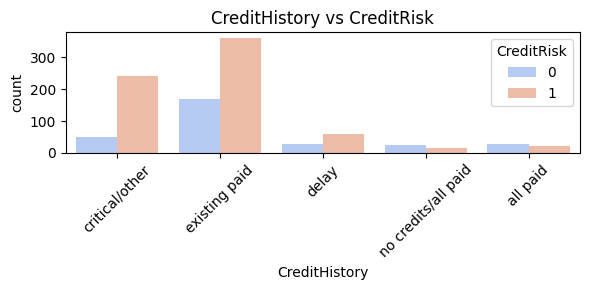

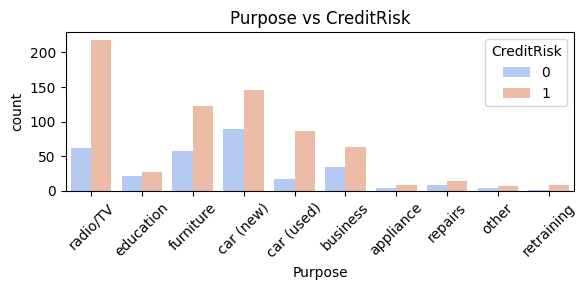

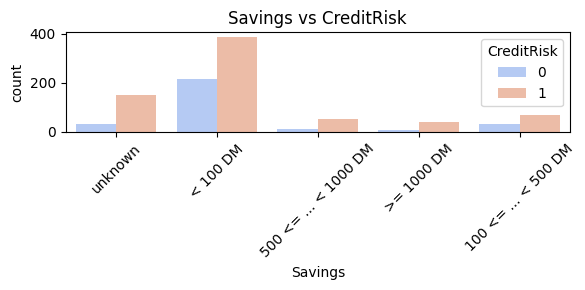

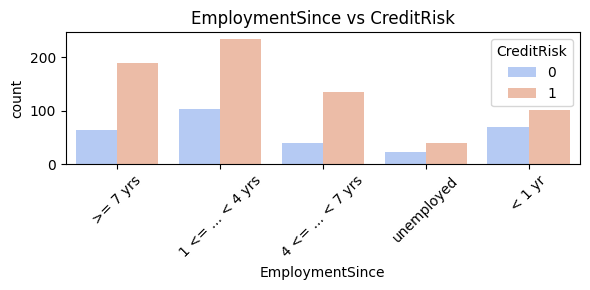

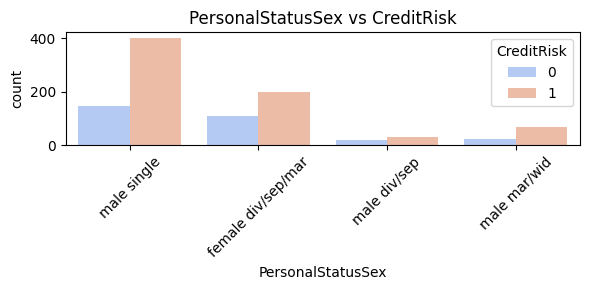

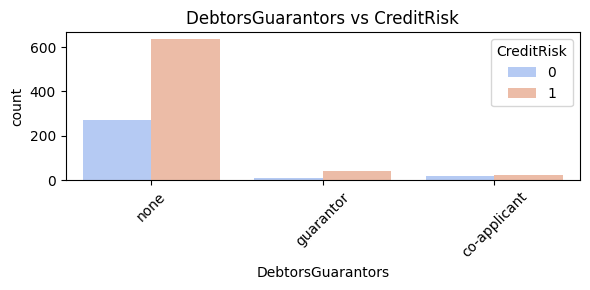

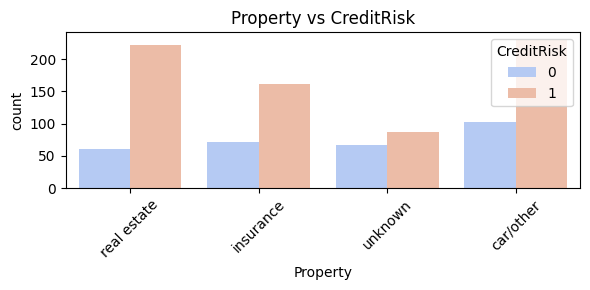

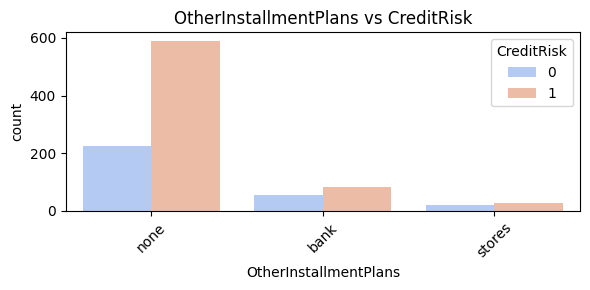

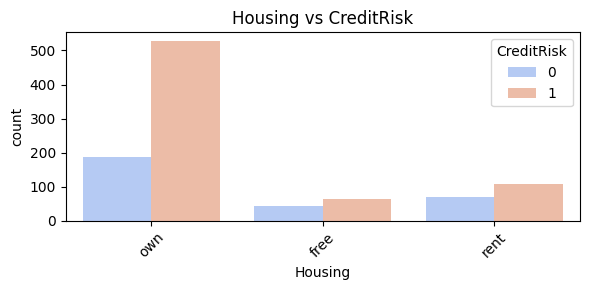

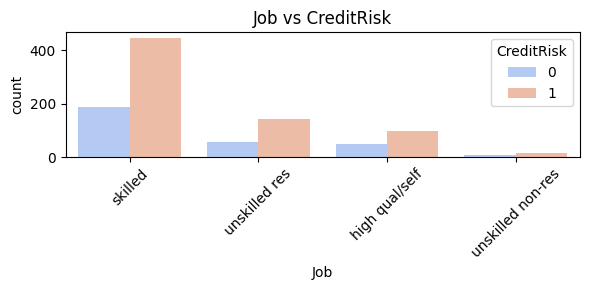

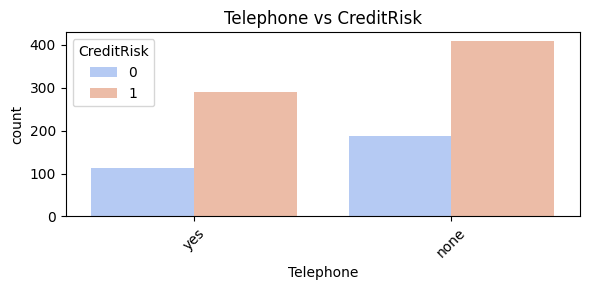

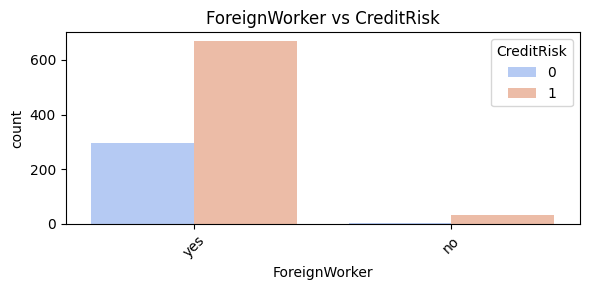

In [ ]:
# Categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Plot countplots
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, data=df, hue='CreditRisk', palette='coolwarm')
    plt.title(f'{col} vs CreditRisk')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

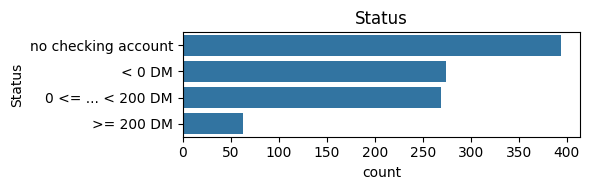

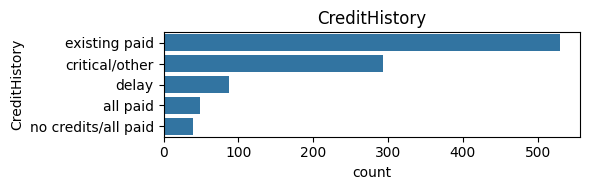

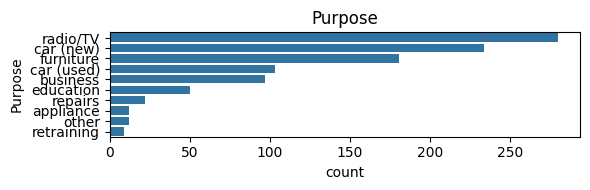

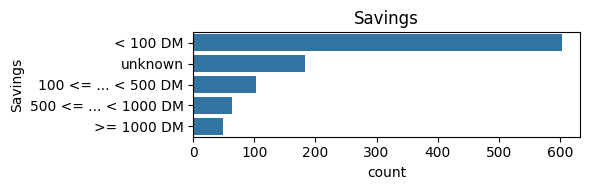

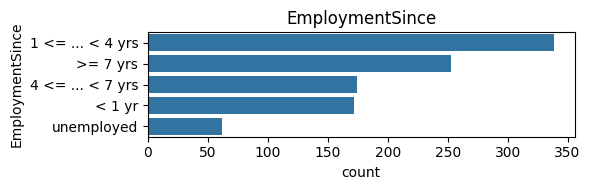

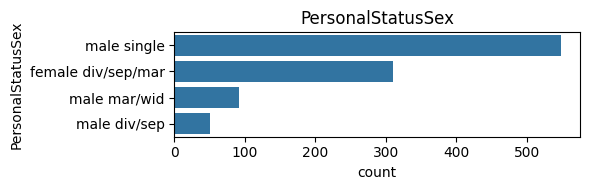

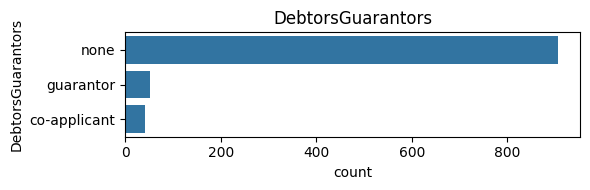

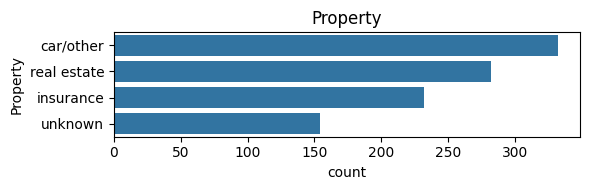

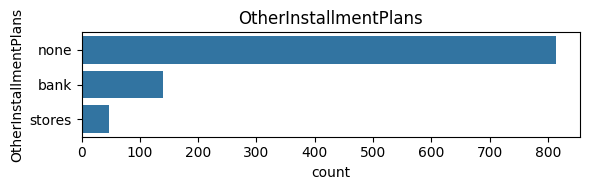

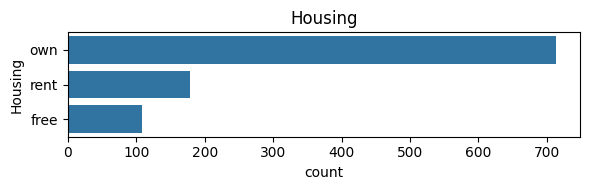

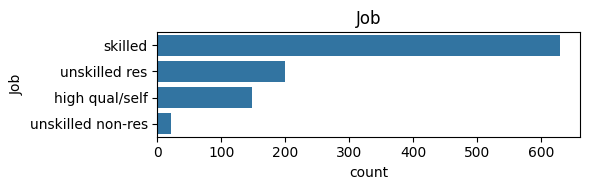

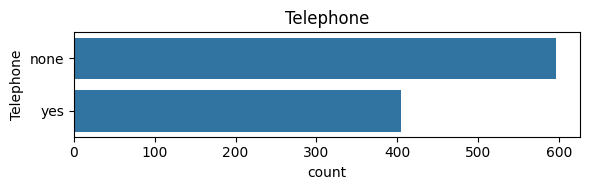

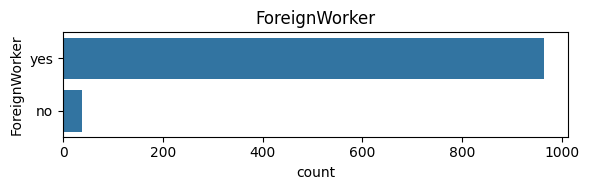

In [ ]:
# Categorical barplots
categorical_cols = [
    'Status', 'CreditHistory', 'Purpose',
    'Savings', 'EmploymentSince', 'PersonalStatusSex',
    'DebtorsGuarantors', 'Property', 'OtherInstallmentPlans',
    'Housing', 'Job', 'Telephone', 'ForeignWorker'
]

for col in categorical_cols:
    plt.figure(figsize=(6,2))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()
    plt.show()

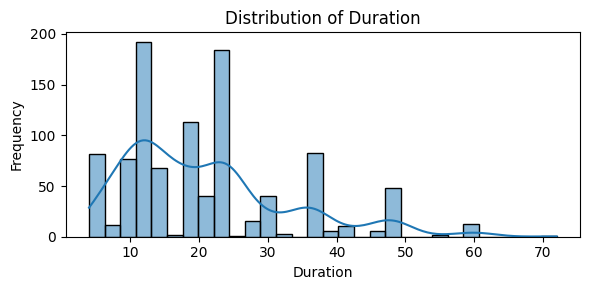

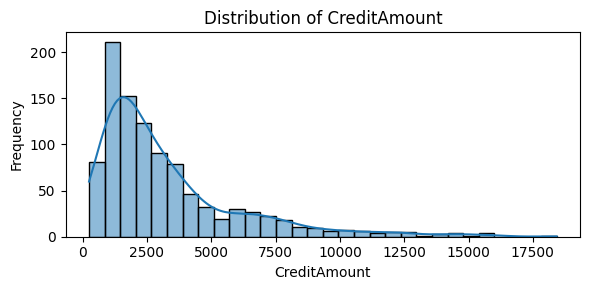

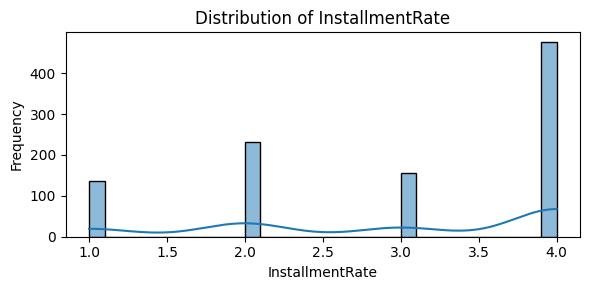

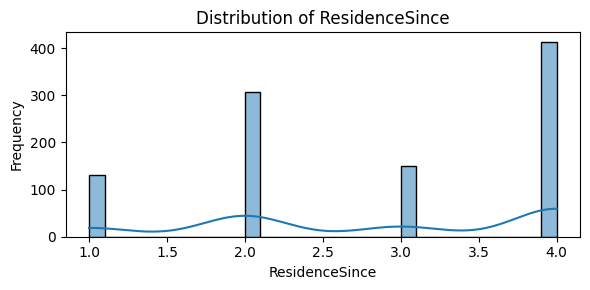

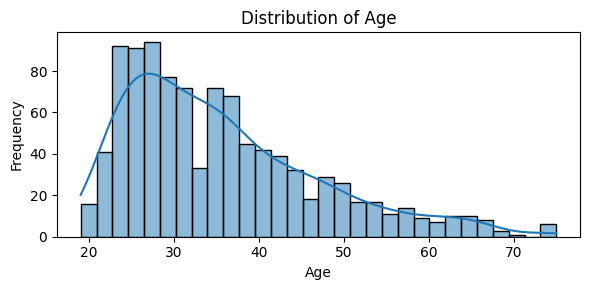

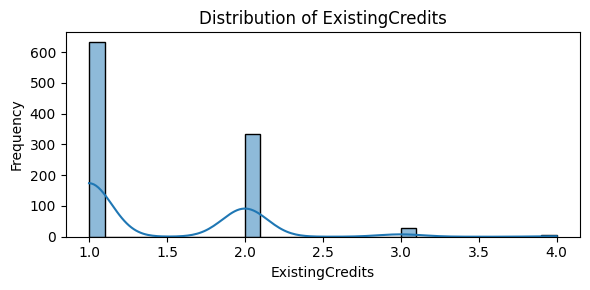

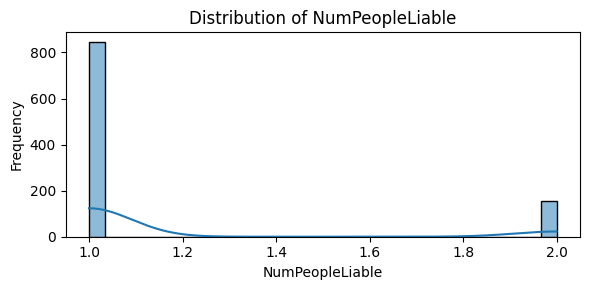

In [ ]:
numeric_features = df.select_dtypes(include=[int, float]).columns.tolist()
numeric_features.remove("CreditRisk")  # remove label if present

# Plot histogram for each numeric feature
for col in numeric_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

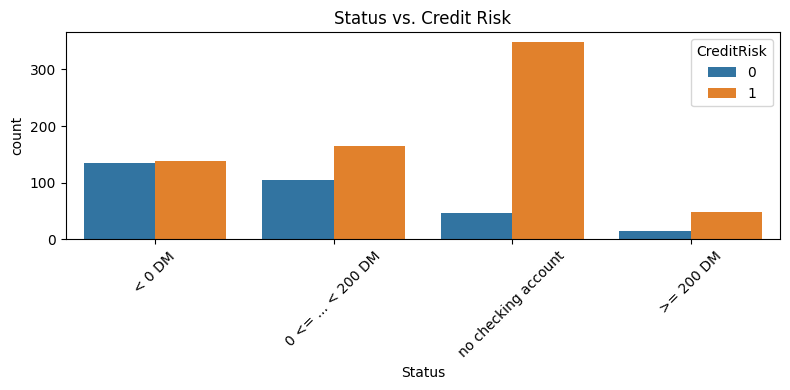

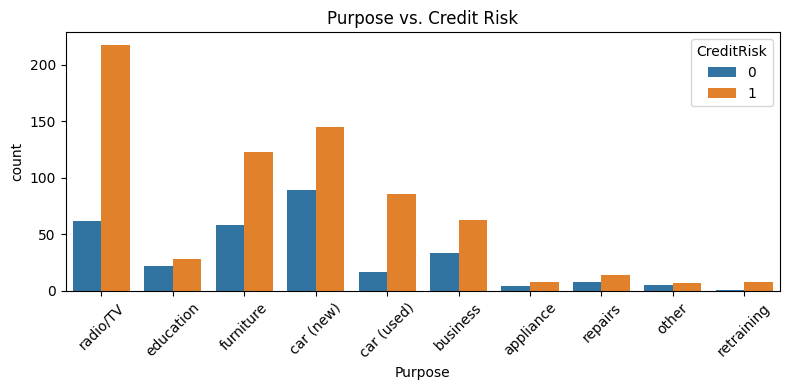

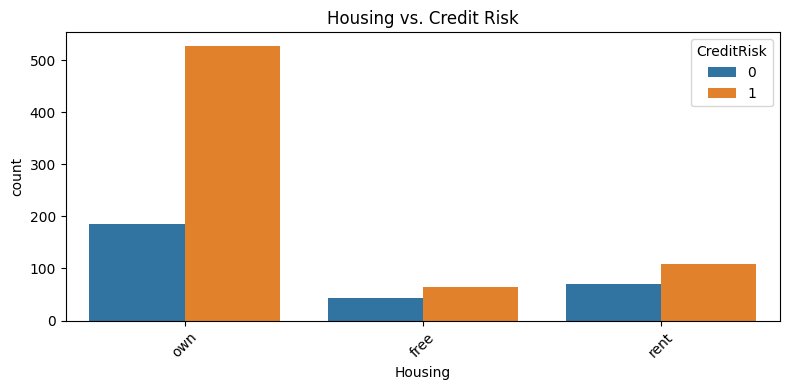

In [ ]:
for col in ['Status', 'Purpose', 'Housing']:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='CreditRisk', data=df)
    plt.title(f"{col.title()} vs. Credit Risk")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Run this if you want to generate a full data profiling report
profile = ProfileReport(df, title="German Credit Data Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 55.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Save the report to an HTML file
profile.to_file("german_credit_profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download("german_credit_profile.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Data Preprocessing

In [16]:
# Copying original data
df_encoded = df.copy()

In [17]:
# Encode all categorical columns using Label Encoding
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [18]:
# View the first few rows
df_encoded.head()

Status  Duration  CreditHistory  Purpose  CreditAmount  Savings  \
0       1         6              1        7          1169        4   
1       0        48              3        7          5951        2   
2       3        12              1        4          2096        2   
3       1        42              3        5          7882        2   
4       1        24              2        2          4870        2   

   EmploymentSince  InstallmentRate  PersonalStatusSex  DebtorsGuarantors  \
0                3                4                  3                  2   
1                0                2                  0                  2   
2                1                2                  3                  2   
3                1                2                  3                  1   
4                0                3                  3                  2   

   ...  Property  Age  OtherInstallmentPlans  Housing  ExistingCredits  Job  \
0  ...         2   67                      1        1                2    1   
1  ...         2   22                      1        1                1    1   
2  ...         2   49                      1        1                1    3   
3  ...         1   45                      1        0                1    1   
4  ...         3   53                      1        0                2    1   

   NumPeopleLiable  Telephone  ForeignWorker  CreditRisk  
0                1          1              1           1  
1                1          0              1           0  
2                2          0              1           1  
3                2          0              1           1  
4                2          0              1           0  

[5 rows x 21 columns]

In [19]:
# Features and target
X = df_encoded.drop("CreditRisk", axis=1)
y = df_encoded["CreditRisk"]

In [20]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
# Print class distribution
print("Train Class Distribution:\n", y_train.value_counts())
print("Test Class Distribution:\n", y_test.value_counts())

Train Class Distribution:
 CreditRisk
1    560
0    240
Name: count, dtype: int64
Test Class Distribution:
 CreditRisk
1    140
0     60
Name: count, dtype: int64


### Feature Scaling

In [22]:
# Identify numeric columns (exclude target)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [23]:
# Initialize scaler
scaler = StandardScaler()

In [24]:
# Fit on training and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

In [25]:
# Convert back to DataFrames (optional for inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

In [26]:
# Replace original numeric columns with scaled ones in original dataframes
X_train.update(X_train_scaled_df)
X_test.update(X_test_scaled_df)

In [27]:
# Preview
X_train.head()

Status  Duration  CreditHistory   Purpose  CreditAmount   Savings  \
675  1.110019  0.755149      -1.162918  1.167957      0.485384 -0.124456   
703 -1.303066  0.755149      -0.216494 -1.425102     -0.246578 -1.902391   
12  -1.303066 -0.726746       0.729929  1.167957     -0.584573 -0.124456   
845 -1.303066  0.014201       0.729929  0.303604      0.285331  1.653480   
795  1.110019 -0.973728       0.729929  0.303604     -0.319522 -1.902391   

     EmploymentSince  InstallmentRate  PersonalStatusSex  DebtorsGuarantors  \
675        -0.397319         0.905268          -1.380517           0.307284   
703         1.112681         0.905268           0.837181           0.307284   
12         -1.152318        -1.797024          -1.380517           0.307284   
845        -0.397319        -0.896260           0.837181           0.307284   
795         0.357681        -0.896260          -1.380517           0.307284   

     ResidenceSince  Property       Age  OtherInstallmentPlans   Housing  \
675        1.044365 -1.174602 -0.825479               0.188222  1.783509   
703       -0.758207 -0.234920  0.493705               2.578349 -0.136824   
12        -1.659492 -1.174602 -1.177262               0.188222 -0.136824   
845        0.143079 -1.174602 -0.033969               0.188222 -0.136824   
795        1.044365 -0.234920 -1.177262               0.188222  1.783509   

     ExistingCredits       Job  NumPeopleLiable  Telephone  ForeignWorker  
675        -0.719852 -1.350180        -0.442509   1.221561       0.190445  
703         1.035885 -0.289135        -0.442509  -0.818625       0.190445  
12         -0.719852 -0.289135        -0.442509   1.221561       0.190445  
845        -0.719852 -0.289135        -0.442509   1.221561       0.190445  
795        -0.719852 -0.289135        -0.442509  -0.818625       0.190445

In [29]:
import joblib

In [30]:
joblib.dump(label_encoders, "label_encoders.joblib")

['label_encoders.joblib']

### Handle Imbalanced Data

In [31]:
print("\nClass distribution before balancing:")
print(y_train.value_counts(normalize=True))


Class distribution before balancing:
CreditRisk
1    0.7
0    0.3
Name: proportion, dtype: float64


In [32]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [120]:
# Option 2: Under-sampling (alternative to SMOTE)
# under_sampler = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = under_sampler.fit_resample(X_train_processed, y_train)

In [121]:
# Confirm class balance
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

Resampled class distribution:
 CreditRisk
1    560
0    560
Name: count, dtype: int64


In [35]:
print("\nClass distribution before balancing:")
print(y_train_resampled.value_counts(normalize=True))


Class distribution before balancing:
CreditRisk
1    0.5
0    0.5
Name: proportion, dtype: float64


### Model Training - Random Forest

In [36]:
# Train a basic Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced' )
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

### Model Evaluation

In [37]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

In [38]:
# Predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [39]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.73


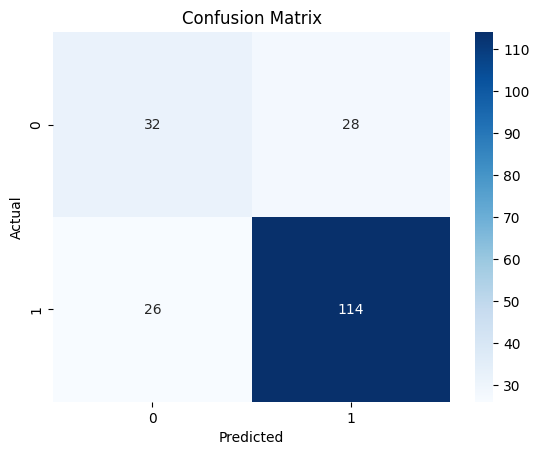

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.53      0.54        60
           1       0.80      0.81      0.81       140

    accuracy                           0.73       200
   macro avg       0.68      0.67      0.68       200
weighted avg       0.73      0.73      0.73       200



In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)

AUC Score: 0.7725


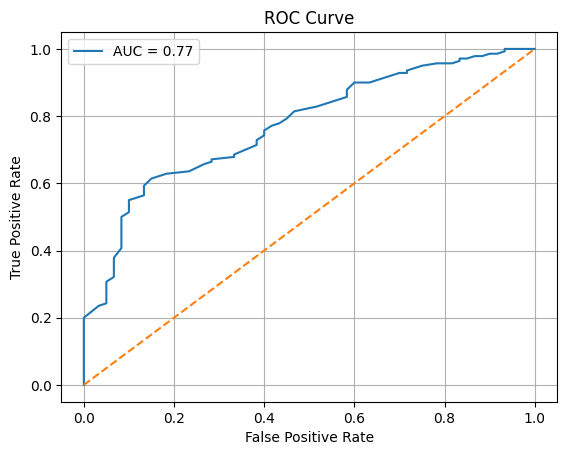

In [43]:
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

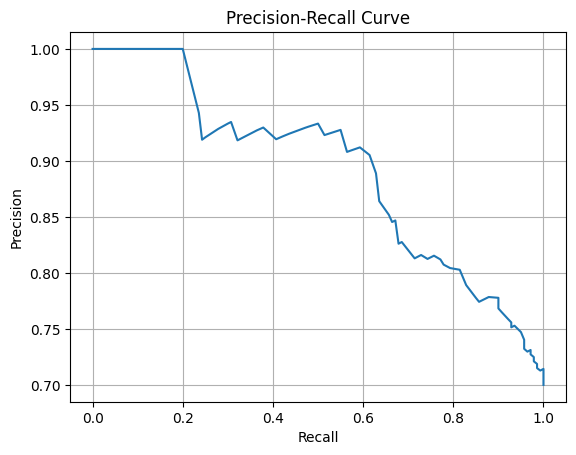

In [44]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [49]:
from sklearn.metrics import precision_score, recall_score

threshold = 0.4  # Try 0.4 instead of 0.5
y_pred_thresh = (y_proba >= threshold).astype(int)

print("New Confusion Matrix at threshold 0.4:")
print(confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

New Confusion Matrix at threshold 0.4:
[[ 18  42]
 [ 10 130]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.30      0.41        60
           1       0.76      0.93      0.83       140

    accuracy                           0.74       200
   macro avg       0.70      0.61      0.62       200
weighted avg       0.72      0.74      0.71       200



### Hyperparameter Tuning (RandomizedSearchCV)

In [52]:
# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],                      # Reduced from 30 because of overfitting
    'min_samples_split': [5, 10],                   # Increase slightly
    'min_samples_leaf': [2, 4],                     # Increase slightly
    'max_features': ['sqrt'],
    'bootstrap': [True]                             # Set to True for better generalization
}

In [53]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced' )

In [54]:
# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [55]:
# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 15, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1', verbose=1)

In [56]:
# Best model
best_rf = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)

Best Parameters:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [ ]:
import joblib

# Save the best model
joblib.dump(best_rf, "tuned_random_forest_model.joblib")

['tuned_random_forest_model.joblib']

In [ ]:
# Download the file
files.download("tuned_random_forest_model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluate Tuned Model

#### We have handled overfitting by adjusting the parameters and iterations.

In [57]:
# Predict on test data using tuned model
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

In [58]:
# Accuracy
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))

Tuned Model Accuracy: 0.715


In [59]:
# Check training accuracy
train_pred = best_rf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_pred))

# Already computed:
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned))

Train Accuracy: 0.975
Test Accuracy: 0.715


Although a previous model had 76% accuracy, it showed signs of overfitting (Train = 100%). After tuning with stricter regularization, the model generalized better (Train = 97.5%, Test = 71.5%). This makes it more reliable for real-world use.

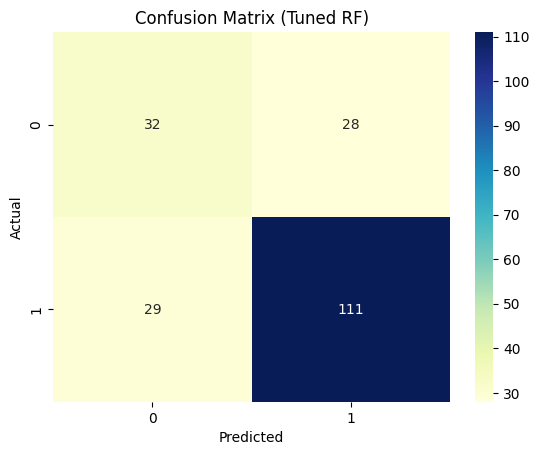

In [60]:
# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix (Tuned RF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
# Classification Report
print("\nTuned Model Classification Report:\n", classification_report(y_test, y_pred_tuned))


Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53        60
           1       0.80      0.79      0.80       140

    accuracy                           0.71       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.72      0.71      0.72       200



Tuned Model AUC Score: 0.785952380952381


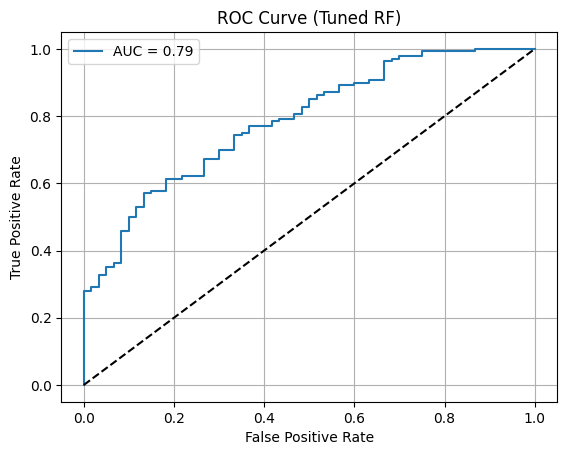

In [ ]:
# ROC Curve and AUC
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
print("Tuned Model AUC Score:", roc_auc_tuned)

plt.plot(fpr_tuned, tpr_tuned, label=f"AUC = {roc_auc_tuned:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned RF)")
plt.legend()
plt.grid(True)
plt.show()

### Cross-validation on the final model

In [ ]:
# Use 5-fold CV with F1 scoring
cv_scores = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

print("Cross-Validation F1 Scores:", cv_scores)
print("Average F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.75889328 0.76612903 0.88151659 0.89756098 0.91162791]
Average F1 Score: 0.8431455566309403


In [62]:
threshold = 0.4
y_pred_thresh_tuned = (y_proba_tuned >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_thresh_tuned))
print(classification_report(y_test, y_pred_thresh_tuned))

[[ 20  40]
 [  8 132]]
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        60
           1       0.77      0.94      0.85       140

    accuracy                           0.76       200
   macro avg       0.74      0.64      0.65       200
weighted avg       0.75      0.76      0.73       200



### Feature Importance Plot

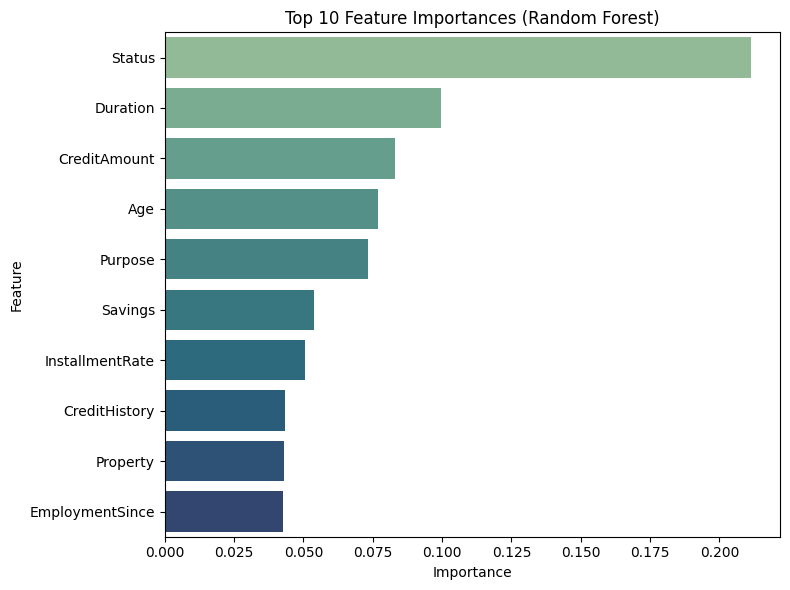

In [ ]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create a sorted DataFrame
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10), palette='crest')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

## Sample

In [63]:
new_applicant = {
    "Status": "no checking account",                       # A14 → 'no checking account'
    "Duration": 24,
    "CreditHistory": "critical/other",                     # A34 → 'critical/other'
    "Purpose": "radio/TV",                                 # A43 → 'radio/TV'
    "CreditAmount": 2500,
    "Savings": "< 100 DM",                                 # A61 → '< 100 DM'
    "EmploymentSince": "1 <= ... < 4 yrs",                 # A73 → '1 <= ... < 4 yrs'
    "InstallmentRate": 4,
    "PersonalStatusSex": "male single",                    # A93 → 'male single'
    "DebtorsGuarantors": "none",                           # A101 → 'none'
    "ResidenceSince": 3,
    "Property": "real estate",                             # A121 → 'real estate'
    "Age": 35,
    "OtherInstallmentPlans": "none",                       # A143 → 'none'
    "Housing": "own",                                      # A152 → 'own'
    "ExistingCredits": 1,
    "Job": "skilled",                                      # A173 → 'skilled'
    "NumPeopleLiable": 1,
    "Telephone": "none",                                   # A191 → 'none'
    "ForeignWorker": "yes"                                 # A201 → 'yes'
}

In [64]:
# Convert to DataFrame
new_app_df = pd.DataFrame([new_applicant])

In [65]:
# Apply label encoders
for col in new_app_df.select_dtypes(include='object').columns:
    le = label_encoders[col]
    new_app_df[col] = le.transform(new_app_df[col])

In [66]:
# Scale numeric features
new_app_df[numeric_cols] = scaler.transform(new_app_df[numeric_cols])

In [67]:
# Predict using trained model
prediction = best_rf.predict(new_app_df)[0]
proba = best_rf.predict_proba(new_app_df)[0][1]

In [68]:
# Show result
if prediction == 1:
    print(f"✅ Approved (Good Credit) - Probability: {proba:.2f}")
else:
    print(f"❌ Rejected (Bad Credit) - Probability: {proba:.2f}")

✅ Approved (Good Credit) - Probability: 0.96


### Downloading models

In [69]:
joblib.dump(best_rf, "tuned_random_forest_model.joblib")

['tuned_random_forest_model.joblib']

In [70]:
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [71]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [72]:
import json
with open("columns.json", "w") as f:
    json.dump({
        "numeric": numeric_cols.tolist(),
        "categorical": list(label_encoders.keys())
    }, f)

In [74]:
import json

# Combine all mappings into one dictionary
all_mappings = {
    "status_map": status_map,
    "credit_history_map": credit_history_map,
    "purpose_map": purpose_map,
    "savings_map": savings_map,
    "employment_map": employment_map,
    "personal_status_map": personal_status_map,
    "other_debtors_map": other_debtors_map,
    "property_map": property_map,
    "other_installment_map": other_installment_map,
    "housing_map": housing_map,
    "job_map": job_map,
    "telephone_map": telephone_map,
    "foreign_worker_map": foreign_worker_map
}

# Save to JSON file
with open("mappings.json", "w") as f:
    json.dump(all_mappings, f, indent=4)